# Generate SHARKFINS-artifact Full Disk images of GOES-R NetCDF files and upload them to GitLab database.

https://gitlab.com/adomakor412/goes-r_fd_image

In [1]:
import sys
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from pathlib import Path
from subprocess import Popen
import itertools
from pyproj import Proj
import pyproj
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
import os
import os.path as op
import glob
from convertdate import gregorian, ordinal
from multiprocessing import Pool
import re

import warnings
#warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger()

/home/radomako/.conda/envs/adomako/lib/python3.9/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


## Paths

In [2]:
store = '../artifacts/'
sharkfins_FD_NC = '/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/'
#caterpillar_FD_NC = '/scratch/gops/amqpfind/adomako_data/l1b_imagery_caterpillar_track/'

## Functions for unfiltered cloud mask

In [3]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    
    planck_fk1 = abs(planck_fk1)
    planck_fk2 = abs(planck_fk2)
    planck_bc1 = abs(planck_bc1)
    planck_bc2 = abs(planck_bc2)
    
    invRad = np.array(abs(rad))**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2)
    return T



def download(url,toPath, saveName):
    cmd = [ 'wget ' + url +' -P ' + toPath +' -O '+ saveName]#if re.search('C07',url)
    #print(cmd)
    pid = Popen(cmd, shell=True)
    pid.communicate()
    return

## Load data

In [4]:
# Sat = [16,17]
# #band = range(7,17)
# year = [2021]
# month = list(range(1,3))
# day = list(range(1,32))
# hour = list(range(1,24))

In [5]:
# search = list(itertools.product(Sat,\
#         #band,\
#         year,\
#         month,\
#         day,\
#         hour))

## Execution

In [6]:
def execute(artifact,storage):
    filelog = open('sharkfin.txt','w')

    #for SS, bb, yyyy, mm, dd, hr in chunk:
    #SS, bb, yyyy, mm, dd, hr = chunk
#     SS, yyyy, mm, dd, hr = chunk
#     bb = band
#     SS, bb, yyyy, mm, dd, hr = \
#         str(SS).zfill(2),\
#         str(bb).zfill(2),\
#         str(yyyy).zfill(4),\
#         str(mm).zfill(2),\
#         str(dd).zfill(2),\
#         str(hr).zfill(2)



#     #Create Directories    
#     cond2 = os.path.exists(f'{storage}/{yyyy}')
#     cond3 = os.path.exists(f'{storage}/{yyyy}/{DDD}')
#     cond4 = os.path.exists(f'{storage}/{yyyy}/{DDD}/{bb}')

#     if not cond2:
#         #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
#         #make di
#             #Create Directoriesrectory per year
#         cmd = [f'mkdir {storage}/{yyyy}']
#         pid = Popen(cmd, shell=True) 
#         pid.communicate()

#     if not cond3:
#         #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
#         #make directory per year
#         cmd = [f'mkdir {storage}/{yyyy}/{DDD}']
#         pid = Popen(cmd, shell=True) 
#         pid.communicate()
        
#     if not cond4:
#         #KEEP CONDITION AS A DYNAMIC F-STRING OTHERWISE VARIABLE IS STATIC, utilize loop
#         #make directory per year
#         cmd = [f'mkdir {storage}/{yyyy}/{DDD}/{bb}']
#         pid = Popen(cmd, shell=True) 
#         pid.communicate()

    try:
        #Not a cd command, use absolute path
        #netcdf = glob.glob(f'~/arcdata/goes/grb/goes{SS}/{yyyy}/{yyyy}_{mm}_{dd}_{DDD}/abi/L1b/RadF/')
        netcdf = []
        for CH in range(7,17):
            channel = str(CH).zfill(2)
            myGlob = glob.glob(op.join(artifact,'*C{}*.nc'.format(channel)))
            netcdf += myGlob

        print(netcdf, file=filelog)

        for file in netcdf:
            print(file)
            
            naming = f'{os.path.basename(os.path.normpath(file[:-3]))}_UTC_224x224_BW.png'
            savePath = op.join(store,storage)
            #print('BREAKER')
            if os.path.isfile(op.join(savePath,naming)):
                continue
            #print('BREAKER')
            #file = os.path.basename(os.path.normpath(file))
            i = file.find('_s',-55)#+2
            yyyy = file[i+2: i+6]
            #print(yyyy)
            DDD = file[i+6: i+9]
            HH = file[i+9: i+11]
            MM = file[i+11: i+13]
            ss = file[i+13: i+15]
            SS = file[i-2: i]
            bb = file[i-6: i-4]
            mm = str(ordinal.to_gregorian(int(yyyy),int(DDD))[1]).zfill(2)
            dd = str(ordinal.to_gregorian(int(yyyy),int(DDD))[2]).zfill(2)
            
            my_dpi = 96#192
            resolution = 5424
            downsize_x = 224
            downsize_y = 224
            #print('BREAKER')
            GOES_R = xr.open_dataset(file)
            GOES_image = GOES_R['Rad']

            planck_fk1 = float(GOES_R['planck_fk1'].data)
            planck_fk2 = float(GOES_R['planck_fk2'].data) 
            planck_bc1 = float(GOES_R['planck_bc1'].data)                       
            planck_bc2 = float(GOES_R['planck_bc2'].data)
            #Need not convert projection: using full image, no pyproj interpolation of region of interest
            Kelvin_GOES_image = Rad2BT(GOES_image, planck_fk1, planck_fk2, planck_bc1, planck_bc2)

            #Call pixelage before rendering
            plt.figure(figsize=(downsize_x/my_dpi, downsize_y/my_dpi), dpi=my_dpi)
            plt.grid(None)
            plt.axis('off')
            title = f'Brightness Temperature in Kelvin \n Full Disk GOES-{SS} Image Band{bb}'
            ttl = plt.title(f"{title}\n Date {mm}-{dd}, Year {yyyy}, \n Day {DDD}, Time {HH}:{MM}:{ss}",\
                       fontsize="x-large", fontweight='bold', pad = 6.0)
            ttl.set_position([.5, 1.05])
            fig1=plt.imshow(Kelvin_GOES_image,cmap='Greys',interpolation='none',vmin=180,vmax=300)
            cbar = plt.colorbar()
            cbar.ax.set_ylabel('Kelvin')
            fig1.figure.savefig( op.join(savePath,naming) )
            
            naming = f'{os.path.basename(os.path.normpath(file[:-3]))}_UTC_224x224.png'
            cbar.remove()
            fig1 = plt.imshow(Kelvin_GOES_image, vmin=180, vmax=300, cmap='plasma')
            cbar = plt.colorbar()
            cbar.ax.set_ylabel('Kelvin')
            plt.grid(None) #Call after the imshow, redraws
            plt.axis('off')#Call after the imshow, redraws; "layer" to previous drawing
            title = f'Brightness Temperature in Kelvin \n Full Disk GOES-{SS} Image Band{bb}'
            ttl = plt.title(f"{title}\n Date {mm}-{dd}, Year {yyyy}, \n Day {DDD}, Time {HH}:{MM}:{ss}",\
                       fontsize="x-large", fontweight='bold', pad = 6.0)
            ttl.set_position([.5, 1.05])
            fig1.figure.savefig(op.join(savePath,naming))
                
            plt.close('all')
            GOES_R.close()

    except ValueError as e:
        print('THERE IS AN ERROR')
        print('\n', file = filelog)
        print(file, file = filelog)
        print(e, file = filelog)
        print('\n', file = filelog)

    filelog.close()
    return

/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G17_s20193491650341_e20193491659419_c20193491659465.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G17_s20193600950342_e20193600959420_c20193600959460.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G16_s20193621310223_e20193621319542_c20193621320000.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G17_s20200331510321_e20200331519399_c20200331519442.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G17_s20200392010321_e20200392019399_c20200392019444.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G16_s20200481650201_e20200481659520_c20200481659583.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C07_G17_s20200991840320_e20200991849399_c20200991849444.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_AB

/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G17_s20193491650341_e20193491659408_c20193491659459.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G17_s20193550320326_e20193550329392_c20193550329452.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G16_s20193571600221_e20193571609529_c20193571609593.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G17_s20193572250333_e20193572259400_c20193572259454.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G17_s20193580400334_e20193580409401_c20193580409455.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G16_s20200050600214_e20200050609522_c20200050609587.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_ABI-L1b-RadF-M6C11_G16_s20200060000211_e20200060009518_c20200060009581.nc
/scratch/gops/amqpfind/adomako_data/l1b_imagery_sharkfin/OR_AB

KeyboardInterrupt: 

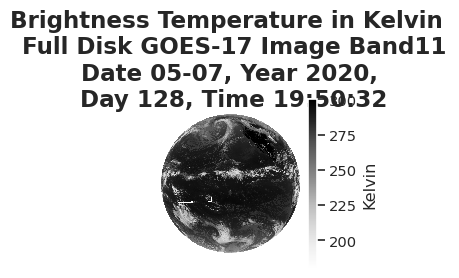

In [7]:
#artifactList = [caterpillar_FD_NC]
artifactList = [sharkfins_FD_NC]

for artifact in artifactList:
    if artifact == sharkfins_FD_NC:
        storage = 'sharkfin'
    else:
        storage = 'caterpillar'
    execute(artifact,storage)

In [ ]:
#artifact = caterpillar_FD_NC
artifactList = [sharkfins_FD_NC]

netcdf = []
for CH in range(7,17):
    channel = str(CH).zfill(2)
    myGlob = glob.glob(op.join(artifact,'*C{}*.nc'.format(channel)))
    netcdf += myGlob
#print (netcdf)